# DNN Image Classification

Apply the deep learning model [MobileNet-SSD](https://arxiv.org/abs/1801.04381) for image classification using `opencv`. [This tutorial](https://heartbeat.fritz.ai/real-time-object-detection-on-raspberry-pi-using-opencv-dnn-98827255fa60) served as a starting point for this applet.

In [1]:
image_filename = ''
image_filename__format = 'upload'

image_url = ''
image_url__placeholder = 'Either upload an image or specify a URL'

confidence_threshold = 0.3

# Loading model
import cv2
model = cv2.dnn.readNetFromTensorflow('models/frozen_inference_graph.pb',
                                      'models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt')

In [2]:
from urllib.request import urlretrieve

if not image_filename:
    if not image_url:
        #image_url = 'https://www.hellowonderful.co/wp-content/uploads/2017/10/anna-ream-comfort-objects-kids.jpg'
        image_url = 'http://blog.trentbell.com/wp-content/uploads/2015/07/unispace-interior-photo-commercial-office-5.jpg'
    image_filename, _ = urlretrieve(image_url)
    
image = cv2.imread(image_filename)

In [3]:
def resize_image(image, max_size=800):
    orig_max = max(image.shape[:2])
    if orig_max <= max_size:
        return image
    scale = max_size / orig_max
    dim = (int(image.shape[1]*scale), int(image.shape[0]*scale))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

image = resize_image(image)

In [4]:
# Pretrained classes in the model
classNames = {0: 'background',
              1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus',
              7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant',
              13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat',
              18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear',
              24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag',
              32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard',
              37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove',
              41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle',
              46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
              51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
              56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
              61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed',
              67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
              75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
              80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock',
              86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'}


def id_class_name(class_id, classes):
    for key, value in classes.items():
        if class_id == key:
            return value

In [5]:
from collections import namedtuple

Rect = namedtuple('Rect', ['x1', 'y1', 'x2', 'y2', 'class_id', 'score'])
def overlapping(r1, r2):
    return (r1.x1 < r2.x1 < r1.x2 and r1.y1 < r2.y1 < r1.y2 or
            r1.x1 < r2.x2 < r1.x2 and r1.y1 < r2.y2 < r1.y2)

In [6]:
colors = [(0,0,255,1),(255,100,50,1),(0,255,255,0),(255,255,1,0),(255,0,255,0),(0,255,0,0)]

def draw_prediction(image, class_id, conf, left, top, right, bottom, color_map):
    if class_id not in color_map:
        color_map[class_id] = colors[len(color_map) % len(colors)]
    color = color_map[class_id][:3]
    text_color = (255,255,255) if color_map[class_id][3] == 1 else (0,0,0)
    
    # Draw a bounding box.
    cv2.rectangle(image, (left, top), (right-left, bottom-top), color)

    label = '%s: %.2f' % (id_class_name(class_id,classNames), conf)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(image, (left, top - labelSize[1]), (left + labelSize[0], top + baseLine), 
                  color, cv2.FILLED)
    cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color)

## testing colors
# color_map = {}
# for i in range(len(colors)):
#     draw_prediction(image, i, 0.5, 5, i*30, 105, i*30+10, color_map)
# with tempfile.NamedTemporaryFile(suffix='.jpg') as f:
#     cv2.imwrite(f.name, image)
#     f.flush()
#     display(Image(data=f.read()))

In [7]:
import tempfile
from IPython.display import display, Image

image_height, image_width, _ = image.shape

# set image as the input
model.setInput(cv2.dnn.blobFromImage(image, size=(300, 300), swapRB=True))
# run the model on the image
output = model.forward()

seen = set()

# draw bounding boxes on identified objects
for detection in sorted(output[0, 0, :, :], key=lambda x: -x[2]):
    confidence = detection[2]
    if confidence > confidence_threshold:
        class_id = detection[1]
        class_name=id_class_name(class_id,classNames)
        score = detection[2]
        x = int(detection[3] * image_width)
        y = int(detection[4] * image_height)
        width = int(detection[5] * image_width)
        height = int(detection[6] * image_height)
        r = Rect(x, y, x+width, y+height, class_id, score)
        # skip overlapping bounding boxes of the same object prediction
        if any(overlapping(r, r2) and r.class_id == r2.class_id for r2 in seen):
            continue
        print(str(str(class_id) + " " + str(detection[2])  + " " + class_name))
        seen.add(r)

color_map = {}
for r in sorted(seen, key=lambda r: r.score):
    draw_prediction(image, r.class_id, r.score, r.x1, r.y1, r.x2, r.y2, color_map)

62.0 0.7935841 chair
62.0 0.74102855 chair
1.0 0.70027566 person
62.0 0.5779187 chair
1.0 0.5635437 person
67.0 0.52777845 dining table
67.0 0.5244081 dining table


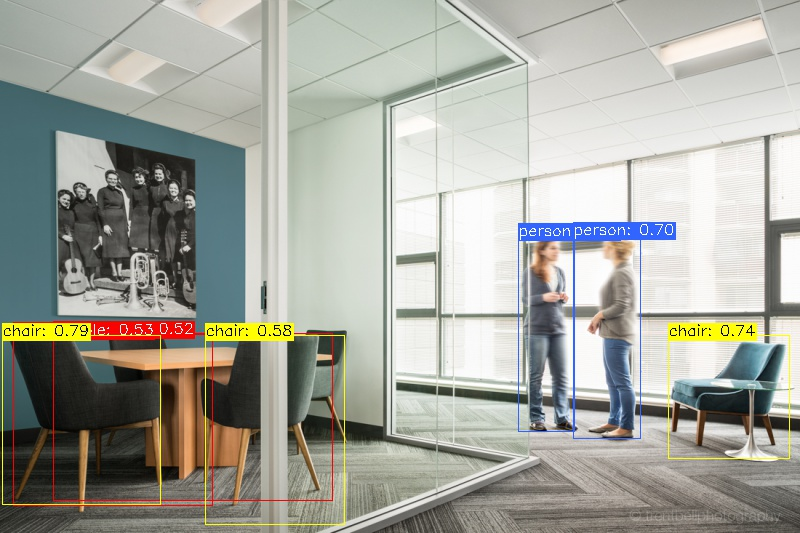

http://blog.trentbell.com/wp-content/uploads/2015/07/unispace-interior-photo-commercial-office-5.jpg


In [8]:
with tempfile.NamedTemporaryFile(suffix='.jpg') as f:
    cv2.imwrite(f.name, image)
    f.flush()
    display(Image(data=f.read()))
#display(Image(data=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

if image_url:
    print(image_url)